In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import matplotlib
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import pickle
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

from scipy.integrate import quad
def integral(x): 
    return np.sqrt(1-v**2) * 1/(1-v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

#n_days = np.array([126000, 212400, 298800, 385200])/86400
#n_days = np.array([1.43, 2.42, 3.41, 4.4])
#n_days = np.array([1.43, 2.42, 3.45, 4.4, 5.4])

#beta, doppler = np.loadtxt('doppler_wo_prolate.txt')
#inter = interp1d(beta, doppler)

#beta1, doppler1 = np.loadtxt('doppler_wo_prolate_inv.txt')
#inter = interp1d(beta1, doppler1)


# Grid points in distance and inclination (theta_jn)
XX = np.loadtxt('./Inclination/figure_4/incl_grid_pts.dat.gz')
YY = np.loadtxt('./Inclination/figure_4/dist_grid_pts.dat.gz')

# Posterior PDF values for the marginal distributions shown in Figure 4
gw_Z = np.loadtxt('./Inclination/figure_4/volumetric_marginal_posterior_pdf.dat.gz')
em_Z = np.loadtxt('./Inclination/figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz')

theta_jns = XX[0, :]; 
dists = YY[:, 0]
d_theta_jn = theta_jns[1] - theta_jns[0]
ourprior = 1/np.sqrt(2*np.pi*7**2)*np.exp(-((180-XX)-21)**2/(2*7)**2)

#plt.plot(dists, d_theta_jn*np.sum(em_Z, axis=0), label='GW prior')
#plt.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW prior')
y = d_theta_jn*np.sum(ourprior*gw_Z, axis=0)
norm = np.trapz(y, dists )
#plt.plot(dists, y/norm, label='GW prior')

In [6]:
#beta

In [7]:
beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Udi_full.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

files = ["./Data/OB1/OB1_3_peaks_with_gaussian_3.pkl", #"./Data/OB1/Inflated_unc_chi1_100x5000.pkl", #"./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", 
         "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", 
         "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.005, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0

n_days = [1.427, 2.417, 3.413, 4.40, 5.40]
mean_dl = []
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
    
    mean_dl.append(np.mean(dl))
    print(np.mean(dl))

49.8743083004031
52.695786621056435
53.584310768037426
63.32472277100049
61.58939770775781


In [8]:
#beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Sadun_2.txt')
#beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Udi_full.txt')
beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Stuart_2.txt')
#beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Stuart.txt')

inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, v_perp, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #v_perp, 1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = v_perp*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

In [9]:
files = ["./Data/OB1/OB1_fit_ratio_vel_perfect_20x1000_inflated_relPCygni.pkl", #"./Data/OB1/Inflated_unc_chi1_100x5000.pkl", #"./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", 
         "./data/OB2/OB2_fit_ratio_vel_perfect_20x1000_inflated_relPCygni.pkl", 
         "./data/OB3/Rel_5.pkl", 
         "./Data/OB4/Rel_3.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*100, 25*150, 22*100, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.005, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
loc_i = [1.01, 0.98]
n_days = [1.43, 2.42, 3.40, 4.40, 5.40]
mean_dl = []
for idx, file in enumerate(files[:2]):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    N = emcee_res.params['N'].value
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(N)*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['vphot'])),
                      vphot, vphot*loc_i[idx], 
                      n_days=n_days[idx])[steady[idx]:]
    
    mean_dl.append(np.mean(dl))
    print(np.mean(dl))
    

44.66380771990026
47.8208747907503


2.752046990957482e-29

In [316]:
pickle_in = open("./Data/OB1/OB1_fit_ratio_vel_perfect_20x1000_inflated_relPCygni.pkl","rb")
emcee_res = pickle.load(pickle_in)
emcee_flatten = emcee_res.flatchain
np.median(emcee_flatten['vphot'])

0.28784291590569594

In [260]:
z = 0.00985; z2 = 0.00952
1/67.54*3e5*z*(1+1.53/2*z), 1/74.04*3e5*z*(1+1.53/2*z), 1/67.54*3e5*z2*(1+1.53/2*z2), 1/74.04*3e5*z2*(1+1.53/2*z2)

(44.08153188851051, 40.21159729538088, 42.59401357417827, 38.85466878444085)

In [265]:
(373)/299792.458, (360)/299792.458,

(0.0012441940750891071, 0.0012008307427133474)

In [359]:
np.std(mean_dl)/np.sqrt(4) / np.mean(mean_dl)

0.004095242699086032

In [360]:
k = np.std(mean_dl)/np.sqrt(4)
1-np.sqrt(k)

0.5811958742897962

In [361]:
3327/299792.458 - 373/299792.458, 3327/299792.458, 373/299792.458

(0.009853483372153412, 0.01109767744724252, 0.0012441940750891071)

In [362]:
72/299792.458, 0.00043*299792.458

(0.0002401661485426695, 128.91075694)

In [327]:
np.sqrt(130**2 + 72**2)/299792.458

0.0004956991409906629

#### Datasets: 

###### OB1: 
"./data/OB2/OB1_fixed_ve_dl_40_large.pkl" - fixed ve = 0.057 single P-cygni

###### OB2: 
"./data/OB2/OB2_3_peaks_fixed_ve.pkl" - fixed ve = 0.11

###### OB3: 
"./data/OB3/OB3_3_peaks_large.pkl" - hits ceiling of ve=1

###### OB4: 
"./Data/OB4/OB4_3_peaks.pkl" - free ve (huge uncertainties, may need longer chain)

In [178]:
z = 0.00985 #52

In [301]:
## deriving relativstic correction velocity from luminosity self-consistently
files = ["./data/OB1/Wrong_Spec_Rel.pkl", "./Data/OB2/Rel/Rel_with_corr_tau_Occult=1_good.pkl", 
         "./data/OB3/Rel_5_Occult=1.pkl", "./Data/OB4/Rel_3.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
n_days = [1.427, 2.417, 3.413, 4.403, 5.40]

v_line = []
v_corr = []
for i in [0,1,2,3,4]: 
    v_perp = np.median( np.array(emcee_flatten['vphot'])     )
    v_line.append( np.median( np.array(emcee_flatten['vphot'])  ) )
    for rep in range(10): 
        for idx, file in enumerate([files[i]]):
            pickle_in = open(file,"rb")
            emcee_res = pickle.load(pickle_in)
            emcee_flatten = emcee_res.flatchain
        
            H0_s1 = 67.54
            dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
            N_1      = np.median( np.array(emcee_flatten['N'])     )
            v_phot_1 = v_perp
        #R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        #v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2 #* (np.sqrt(inter(v_phot_1)))
        
            #R_1 = np.sqrt( np.array(N_1)*10**7/np.pi* inter(v_phot_1)**2  ) *(dl_s1*3.086e+24)
            R_1 = np.sqrt( np.array(N_1)*10**7/inter(v_phot_1)  ) *(dl_s1*3.086e+24)
            v_sn_1 = R_1/n_days[i]/(24*3600*3e10) 
            
            v_perp = v_sn_1
            #print(v_sn_1)
    v_corr.append(v_perp)
v_line = np.roll(v_line, -1)
print(v_corr)
print(v_line*loc)

[0.2862133865100314, 0.22282116912617603, 0.1819465707628981, 0.12239187235891985, 0.11140962710239208]
[0.2547796  0.2433008  0.19134919 0.16290437 0.23694902]


In [180]:
(v_corr - v_line*loc)/(v_corr + v_line*loc)

array([-0.01910724, -0.0439362 , -0.02518812, -0.14200152, -0.09800395])

In [181]:
(v_corr - v_line)/(v_corr + v_line)

array([-0.00920799, -0.04643735, -0.03681112, -0.17892174, -0.13538404])

In [337]:
1/42.5

0.023529411764705882

In [11]:
#loc = [1.027, 0.99, 0.977, 0.927, 0.927]
loc = [1.022, 0.995, 0.977, 0.927, 0.927]
scale = [0.018, 0.016, 0.023, 0.04, 0.05]

#loc = [1.0, 1.0, 1.0, 1.0, 1.0]
#scale = [0.01, 0.01, 0.01, 0.01, 0.01]


43.59386780763691 0.36247133568492584
44.54993567695543 0.8679182522942049
46.86706531724233 0.4128197549280937
46.63494930780098 0.8552748515034417
Mu = 45.607625051957086 pm 0.6080745443721792


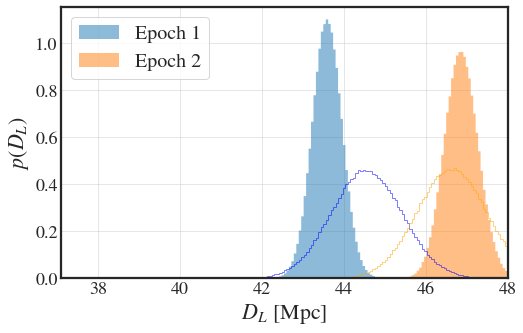

In [13]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.427, 2.417, 3.413, 4.403, 5.40]

#files = ["./data/OB1/Rel/Rel_long_Occult_Free.pkl", "./Data/OB2/Rel/Rel_with_corr_tau_Occult=1_good.pkl", 
#         "./data/OB3/Rel_5_Occult=1.pkl", "./Data/OB4/Rel_3.pkl", 
#         "./Data/OB5/OB5_3_filtered_short.pkl" ]  

#files = ["./data/OB1/Rel/Rel_long_Occult_Free.pkl", "./Data/OB2/Rel/Rel_with_corr_tau_Occult=1_good.pkl", 
#         "./data/OB3/Rel_5_Occult=1.pkl", "./Data/OB4/Rel_3.pkl", 
#         "./Data/OB5/OB5_3_filtered_short.pkl" ]

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))
    
steady = [22*100, 25*500, 22*1000, 22*1, 22*3000]
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration

d_m, ds_1, ds_2 = [], [], []
#multi = np.ones(5) 
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
dl_arr = []
temp = []
pdf_list = []

#v_trans = [0.3027603586890268, 0.23065767419934524, 0.18648908131001785, 0.12360283392746943, 0.11219289002551608]
#[0.301863473675959, 0.2304874634877147, 0.18616126881621142, 0.12734451174514327]
#[0.29895594901949607, 0.23304820284725294, 0.18878917019426533]

for idx, file in enumerate(files[:2]):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.normal(loc=loc[idx], scale=scale[idx], size=len(emcee_flatten['vphot']))
    vphot2 = np.array(emcee_flatten['vphot'])*np.random.normal(loc=loc[idx], scale=scale[idx], size=len(emcee_flatten['vphot']))

    
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, vphot, n_days=n_days[idx])[steady[idx]:]
    dl2 = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, vphot2, 
                      n_days=n_days[idx])[steady[idx]:]
    

    h1 = plt.hist(dl, bins=500, histtype='stepfilled', density=True,
                 label='Epoch '+str(idx+1), range=(30,60), alpha=0.5)
    h1 = plt.hist(dl2, bins=500, histtype='step', density=True,
                 range=(30,60), alpha=0.5, color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h1[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl2), np.percentile(dl2,15.9), np.percentile(dl2,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    #print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(np.median(dl), np.std(dl))
    print(np.median(dl2), np.std(dl2))
    #print(emcee_res.params['vphot'])
    #print(np.median(emcee_flatten['N']))
    dl_arr.append(dl)

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)

combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(39, 50, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')

plt.legend(frameon=True, fontsize=20, loc=2)
plt.xlim(37.1, 48)
print('Mu =', mu, 'pm',sigma)

#plt.savefig('Pictures/dl_dist_1.png', dpi=300)

In [472]:
(d_m[1]-d_m[0])/np.sum(sig1**2)**(1/2)

1.7504660938528638

In [473]:
np.sum(sig1**2)**(1/2)

1.2136758849472524

In [474]:
(44.406489582427625-46.52993991883722)/(0.9481631461147218**2+0.9357269253057832**2)**(1/2)

-1.5940138334351734

In [268]:
mu, np.sum(1/sig1**2)**(-1/2)

(45.43159728689345, 0.6064099109780069)

In [146]:
sigma

0.45638366147963505

43.46353404489632 0.35892025483481693
46.77082965971373 0.41238187353978445
48.77247397447456 0.4479190247039099
58.68831318467684 0.535271140381949
57.833627038240714 1.088512726280301


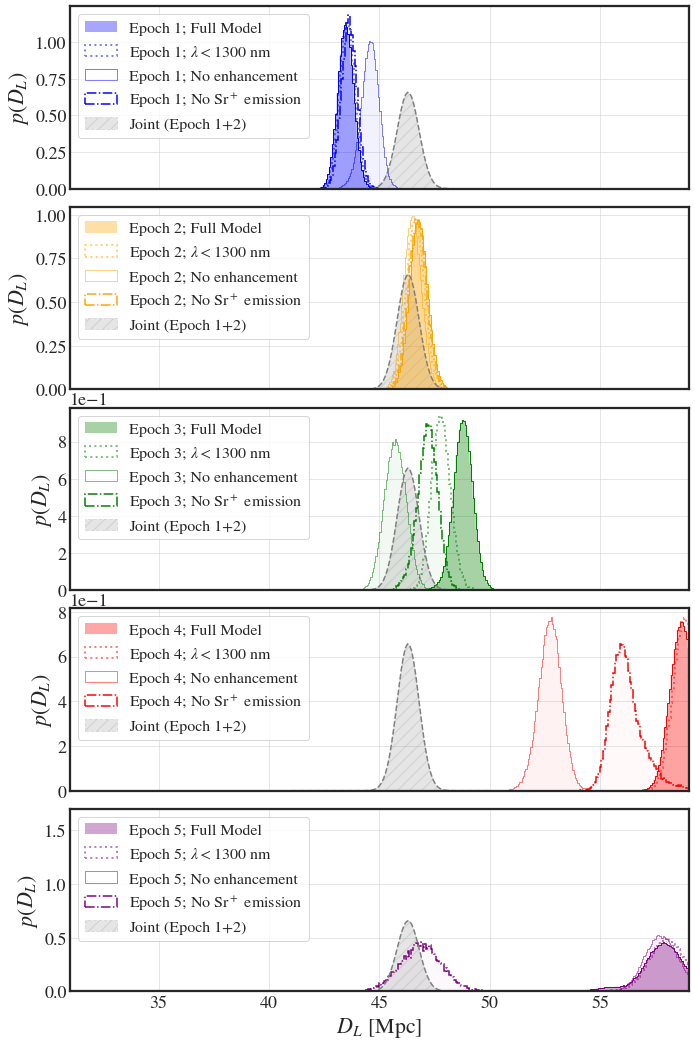

In [460]:
fig,ax = plt.subplots(figsize=(10,15), nrows=5, sharex=True)

#files = ["./data/OB1/Rel/Rel_long_Occult_Free.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
#multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot,vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(32,60), color=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.35,
                 density=True, label='Epoch '+str(idx+1)+'; Full Model', range=(32,60), color=color_list[idx])    
    
    #ax[idx].plot(np.linspace(40, 44.5, 1000), 
    #     interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
    #     , color='grey', alpha=1 )
    #ax[idx].fill_between(np.linspace(40, 44.5, 1000), 
    #     interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
    #             color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    print(np.mean(dl), np.std(dl))


    
files = ["./Data/OB1/OB1_3_peaks_lambda_13000.pkl", "./Data/OB2/OB2_3_peaks_lambda_13000.pkl", 
         "./Data/OB3/OB3_3_peaks_lambda_13000_3.pkl", "./Data/OB4/OB4_3_peaks_lambda_13000_1.pkl",
         "./Data/OB5/OB5_3_peaks_lambda_13000_1.pkl" ] 


steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot,vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(32,60), color=color_list[idx], 
                     label=r'Epoch '+str(idx+1)+'; $\lambda < 1300$ nm', alpha=0.5, linestyle='dotted', linewidth=2)
    #, hatch='--', edgecolor=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.025,
                 density=True, range=(32,60), color=color_list[idx])    


files = ["./Data/OB1/Rel/Rel_long_Occult_Free_No_Emission.pkl", "./Data/OB2/OB2_lambda_3300_22500_woOccult.pkl", 
         "./Data/OB3/OB3_lambda_3300_22500_woOccult.pkl", 
         "./Data/OB4/OB4_lambda_3300_22500_woOccult.pkl", "./Data/OB5/OB5_lambda_3300_22500.pkl"] 

for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(37,60), color=color_list[idx], linewidth=.5, 
                    label='Epoch '+str(idx+1)+'; No enhancement')
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.05,
                 density=True, range=(37,60), color=color_list[idx])    

#files = ["./Data/OB3/OB3_two_Pcygni_40x2000.pkl", "./Data/OB4/OB4_two_Pcygni_28x5000.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 
#for idx, file in enumerate(files):
#    idx = idx+2
#    pickle_in = open(file,"rb")
#    emcee_res = pickle.load(pickle_in)
#    emcee_flatten = emcee_res.flatchain
#    vphot = np.array(emcee_flatten['vphot'])
        
#    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
#                     vphot, n_days=n_days[idx])[steady[idx]:]
    
#    h = ax[idx].hist(dl, bins=500, histtype='step', density=True, range=(37,61), color=color_list[idx], alpha=0.5, #hatch='//', edgecolor=color_list[idx], 
#                     label='Epoch '+str(idx+1)+'; P Cygni 750 nm', linestyle='dashdot', linewidth=1.5)
        
    
files = ["./Data/OB1/OB1_lambda_3300_22500_woOccult_woPeak.pkl", "./Data/OB2/OB2_lambda_3300_22500_woOccult_woPeak.pkl", 
         "./Data/OB3/OB3_lambda_3300_22500_woOccult_woPeak_2.pkl", 
         "./Data/OB4/OB4_lambda_3300_22500_woOccult_woPeak_1.pkl", "./Data/OB5/OB5_lambda_3300_22500_woOccult_woPeak.pkl"] 

steady = [22*1000, 25*1500, 22*1000, 22*1000, 22*1500]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot,vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(30,60), color=color_list[idx], 
                     linestyle='dashdot', linewidth=1.5, label='Epoch '+str(idx+1)+'; No Sr$^+$ emission')
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.025,
                 density=True, range=(30,60), color=color_list[idx])    

    
ax[4].set_ylim(0, 1.7)

plt.xlabel(r'$D_L$ [Mpc]')
ax[0].set_ylabel(r'$p(D_L)$'),  ax[1].set_ylabel(r'$p(D_L)$'),  
ax[2].set_ylabel(r'$p(D_L)$'),  ax[3].set_ylabel(r'$p(D_L)$'),  ax[4].set_ylabel(r'$p(D_L)$') 
#plt.xlim(30.9 , 49.1)

for i in range(5): 
    ax[i].plot( np.linspace(41, 50, 100), 
         combined, color='grey', ls='--', alpha=1)
    ax[i].fill_between( np.linspace(41, 50, 100), 
         combined, color='grey', ls='--', alpha=0.2, label='Joint (Epoch 1+2)', hatch='//')
#ax[0].plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
#         ls='dotted', color='purple', alpha=0.5)

ax[0].legend(frameon=True, fontsize=16, loc=2)
ax[1].legend(frameon=True, fontsize=16, loc=2)
ax[2].legend(frameon=True, fontsize=16, loc=2)
ax[3].legend(frameon=True, fontsize=16, loc=2)
ax[4].legend(frameon=True, fontsize=16, loc=2)

plt.xlim(31, 59)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

#plt.savefig('Pictures/cossin/d_l_Constraints_3_1.png', dpi=300) 

44.56275152114321 0.8669837049792161
46.63848631066323 0.8569738956503417
47.7059201611625 1.2065919307878892
54.43642055618652 2.4011784221584778
53.628681690302045 3.0598376716222786


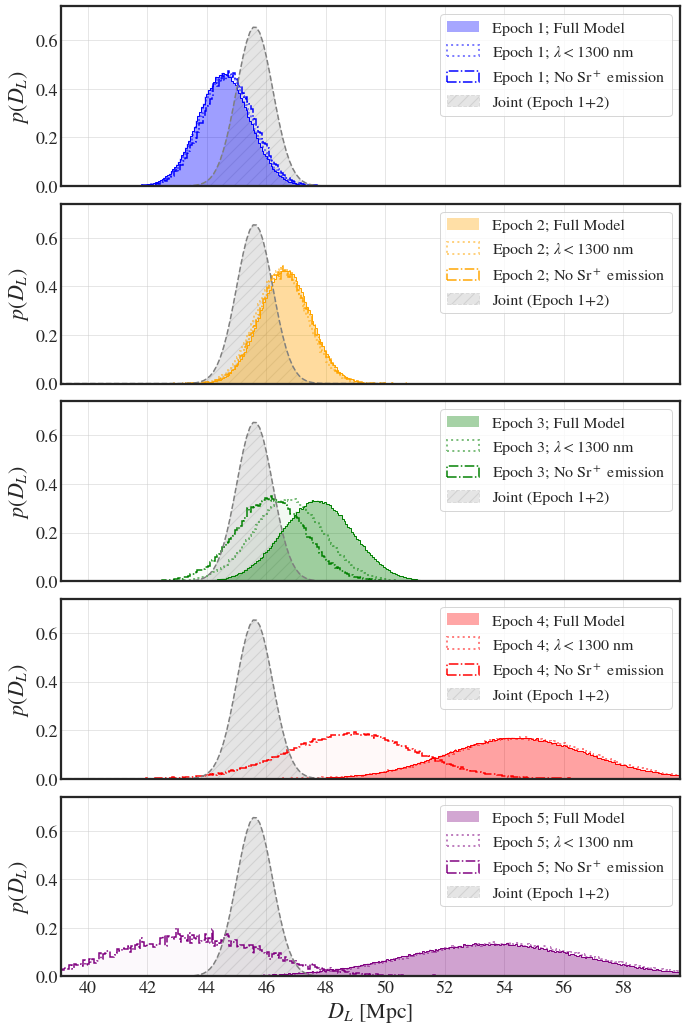

In [14]:
fig,ax = plt.subplots(figsize=(10,15), nrows=5, sharex=True)
up = 60
low = 36
#files = ["./data/OB1/Rel/Rel_long_Occult_Free.pkl",  "./Data/OB2/Rel/Rel_with_corr_tau_Occult=1_good.pkl", 
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
#multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
#multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot']) 
    vphot2 = np.array(emcee_flatten['vphot']) *np.random.normal(loc=loc[idx], scale=scale[idx], size=len(emcee_flatten['vphot']))
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, vphot2, 
                      n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(low,up), color=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.35,
                 density=True, label='Epoch '+str(idx+1)+'; Full Model', range=(low,up), color=color_list[idx])    
    
    #ax[idx].plot(np.linspace(40, 44.5, 1000), 
    #     interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
    #     , color='grey', alpha=1 )
    #ax[idx].fill_between(np.linspace(40, 44.5, 1000), 
    #     interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
    #             color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    print(np.mean(dl), np.std(dl))


    
files = ["./Data/OB1/OB1_3_peaks_lambda_13000.pkl", "./Data/OB2/OB2_3_peaks_lambda_13000.pkl", 
         "./Data/OB3/OB3_3_peaks_lambda_13000_3.pkl", "./Data/OB4/OB4_3_peaks_lambda_13000_1.pkl",
         "./Data/OB5/OB5_3_peaks_lambda_13000_1.pkl" ] 


steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot']) 
    vphot2 = np.array(emcee_flatten['vphot']) *np.random.normal(loc=loc[idx], scale=scale[idx], size=len(emcee_flatten['vphot']))
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, vphot2, 
                      n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(low,up), color=color_list[idx], 
                     label=r'Epoch '+str(idx+1)+'; $\lambda < 1300$ nm', alpha=0.5, linestyle='dotted', linewidth=2)
    #, hatch='--', edgecolor=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.025,
                 density=True, range=(low,up), color=color_list[idx])    
    

#files = ["./Data/OB3/OB3_two_Pcygni_40x2000.pkl", "./Data/OB4/OB4_two_Pcygni_28x5000.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 
#for idx, file in enumerate(files):
#    idx = idx+2
#    pickle_in = open(file,"rb")
#    emcee_res = pickle.load(pickle_in)
#    emcee_flatten = emcee_res.flatchain
#    vphot = np.array(emcee_flatten['vphot'])
        
#    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
#                     vphot, n_days=n_days[idx])[steady[idx]:]
    
#    h = ax[idx].hist(dl, bins=500, histtype='step', density=True, range=(37,61), color=color_list[idx], alpha=0.5, #hatch='//', edgecolor=color_list[idx], 
#                     label='Epoch '+str(idx+1)+'; P Cygni 750 nm', linestyle='dashdot', linewidth=1.5)
        
    
files = ["./Data/OB1/OB1_lambda_3300_22500_woOccult_woPeak.pkl", "./Data/OB2/OB2_lambda_3300_22500_woOccult_woPeak.pkl", 
         "./Data/OB3/OB3_lambda_3300_22500_woOccult_woPeak_2.pkl", 
         "./Data/OB4/OB4_lambda_3300_22500_woOccult.pkl", #./Data/OB4/OB4_lambda_3300_22500_woOccult_woPeak_1.pkl", 
         "./Data/OB5/OB5_lambda_3300_22500_woOccult_woPeak.pkl"] 

steady = [22*1000, 25*1500, 22*1000, 22*1000, 22*1500]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot']) 
    vphot2 = np.array(emcee_flatten['vphot']) *np.random.normal(loc=loc[idx], scale=scale[idx], size=len(emcee_flatten['vphot']))
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, vphot2, 
                      n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(low,up), color=color_list[idx], 
                     linestyle='dashdot', linewidth=1.5, label='Epoch '+str(idx+1)+'; No Sr$^+$ emission')
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.025,
                 density=True, range=(low,up), color=color_list[idx])    


plt.xlabel(r'$D_L$ [Mpc]')
ax[0].set_ylabel(r'$p(D_L)$'),  ax[1].set_ylabel(r'$p(D_L)$'),  
ax[2].set_ylabel(r'$p(D_L)$'),  ax[3].set_ylabel(r'$p(D_L)$'),  ax[4].set_ylabel(r'$p(D_L)$') 
#plt.xlim(30.9 , 49.1)

for i in range(5): 
    ax[i].plot( np.linspace(39, 50, 100), 
         combined, color='grey', ls='--', alpha=1)
    ax[i].fill_between( np.linspace(39, 50, 100), 
         combined, color='grey', ls='--', alpha=0.2, label='Joint (Epoch 1+2)', hatch='//')
#ax[0].plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
#         ls='dotted', color='purple', alpha=0.5)

ax[0].legend(frameon=True, fontsize=16, loc=1)
ax[1].legend(frameon=True, fontsize=16, loc=1)
ax[2].legend(frameon=True, fontsize=16, loc=1)
ax[3].legend(frameon=True, fontsize=16, loc=1)
ax[4].legend(frameon=True, fontsize=16, loc=1)

plt.xlim(39.1, 59.9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
for i in range(5): 
    ax[i].set_ylim(0.0,0.74)
    ax[i].ticklabel_format(axis='y', style='plain')
plt.xticks([40,42,44,46,48,50,52,54,56,58]); 

plt.savefig('Pictures/Final/PDF/Nature_Figures_FigED2.jpeg', dpi=300) 

In [279]:
mu, sigma

(45.42944957209401, 0.6052028569528516)

In [490]:
loc

[1.022, 0.995, 0.977, 0.927, 0.927]

0.27930335760768216
0.23501370584330894


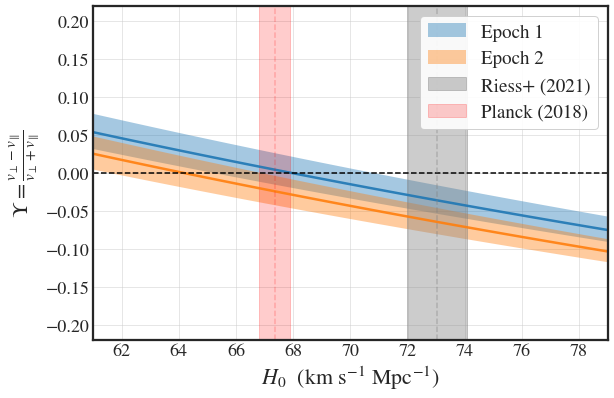

In [519]:
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

#files = ["./data/OB1/Rel/Rel_with_tau_2.pkl", "./data/OB2/Rel/Rel_with_corr_tau_Occult=1.pkl", 
#         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
#         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

H0_p,dH0_p  = 67.36, 0.54
H0_sn,dH0_sn  = 73.03, 1.04
#z = 0.00985 #0.00985 #0.00952 #0.00952 #0.00985 #0.00957 #z = 0.00952
z = 0.00986

reset_plt(18,22)
plt.figure(figsize=(9,6))
n_days = [1.44, 2.40, 3.40, 4.403, 5.40]

loc_i = [1.00, 1.00]

multi = [1.042, 1.042, 1.042, 1.042, 1.042]#[1.0076, 1.0080]#[1.0018, 1.0064]
upsilon_planck = []
dupsilon_planck = []
ls_list = ['-', '-', '-', '-', '-']
hatch_list = ['//', '', '']
for i in [0,1]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        H0_s1 = np.linspace(55, 80, 100)
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
        N_1      = np.median( np.array(emcee_flatten['N'])     )
        v_phot_1 = np.median( np.array(emcee_flatten['vphot']) )
        #R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        #v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2 #* (np.sqrt(inter(v_phot_1)))
        
        #R_1 = np.sqrt( np.array(N_1)*10**7/np.pi* inter(v_phot_1)**2  ) *(dl_s1*3.086e+24)
        R_1 = np.sqrt( np.array(N_1)*10**7/inter(v_phot_1)  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10) #*loc[idx]
        print(v_sn_1[50])
        
        upsilon_s_1 = (v_sn_1-v_phot_1* loc_i[i])/(v_sn_1+v_phot_1* loc_i[i])
        
        upsilon_s_up  = (multi[i]*v_sn_1-v_phot_1* loc_i[i])/(multi[i]*v_sn_1+v_phot_1* loc_i[i])
        upsilon_s_low = (1/multi[i]*v_sn_1-v_phot_1* loc_i[i])/(1/multi[i]*v_sn_1+v_phot_1* loc_i[i])

        plt.plot(H0_s1, upsilon_s_1, ls=ls_list[i], alpha=0.9, linewidth=2.5)#, s=1, alpha=0.2)

        plt.fill_between(H0_s1, upsilon_s_up*(0.00049+0.00985)/0.00985, #upsilon_s_1*multi[i], #*(-0.0004+0.00957)/0.00957, 
                                upsilon_s_low*(-0.00049+0.00985)/0.00985, #upsilon_s_1/multi[i], #*(0.0004+0.00957)/0.00957, 
                         alpha=0.4, label='Epoch '+str(i+1))#, s=1, alpha=0.2)
        
        #ups_binned = []
        #for h_0 in np.arange(65, 76): 
        #    ups_binned.append(upsilon_s_1[(H0_s1<(h_0+1)) & (H0_s1>(h_0-1))])
        #print('Planck',interp1d(H0_s1, upsilon_s_1)(H0_p-dH0_p), interp1d(H0_s1, upsilon_s_1)(H0_p+dH0_p))
        #print('SNe',interp1d(H0_s1, upsilon_s_1)(H0_sn-dH0_sn), interp1d(H0_s1, upsilon_s_1)(H0_sn+dH0_sn))
        
        upsilon_planck.append(interp1d(H0_s1, upsilon_s_1)(H0_p))
#plt.ylim(0.83, 1.17), plt.xlim(65, 76)
#plt.ylim(0.7, 1.3), plt.xlim(60, 80)


plt.ylim(-.22, .22), plt.xlim(61., 79.)

plt.axhline(0, ls='--', color='k')
plt.ylabel(r'$\Upsilon = \frac{v_\perp - v_{\parallel}}{v_\perp + v_\parallel}$'), plt.xlabel(r'$H_0$  (km s$^{-1}$ Mpc$^{-1}$)')

H0_sn  = 73.03; dH0_sn = 1.04
plt.axvline(H0_sn, ls='--', color='grey', alpha=0.4)
plt.fill_between([H0_sn-dH0_sn, H0_sn+dH0_sn], [-2, -2], [2, 2], color='grey', alpha=0.4, label='Riess+ (2021)' )

H0_p  = 67.36; dH0_p = 0.54
plt.axvline(H0_p, ls='--', color='red', alpha=0.2)
plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [-2, -2], [2, 2], color='red', alpha=0.2, label='Planck (2018)' )

plt.ticklabel_format(style='plain')
plt.legend(frameon=True, framealpha=0.9, loc=1, fontsize=19)

#sns.despine(trim=True, offset=20)
#plt.grid(False)

plt.tight_layout()
#plt.savefig('Pictures/Final/PDF/Stuart_Assymetry_H0_2.pdf', dpi=300)

In [526]:
#dists = np.random.normal(loc = mu, scale = sigma, size=len(dl_arr[0]))
z_arr_1 = np.random.normal(loc=0.00986, scale=0.00050, size=10000)
H0_arr_1 = np.random.normal(loc = 67.36, scale=0.54, size=10000)
dist_h0 = 1/H0_arr_1*3e5*z_arr_1*(1+1.53/2*z_arr_1)
print(np.mean(dist_h0), np.std(dist_h0), np.std(dist_h0)/np.mean(dist_h0)/2 )

44.271758731576156 2.2878050121675035 0.025838198862153647


In [468]:
mu, sigma

(45.47577841758501, 0.6065627822262015)

In [514]:
dists = np.random.normal(loc = mu, scale = sigma, size=len(dl_arr[0]))
z_arr_1 = np.random.normal(loc=z, scale=0.00050, size=len(dl_arr[0]))
H0_arr_1 = 1/dists*3e5*z_arr_1*(1+1.53/2*z_arr_1)
print(np.mean(H0_arr_1), np.std(H0_arr_1))

65.62125613834287 3.473690670187328


In [354]:
(74-64.27)/3.5

2.780000000000001

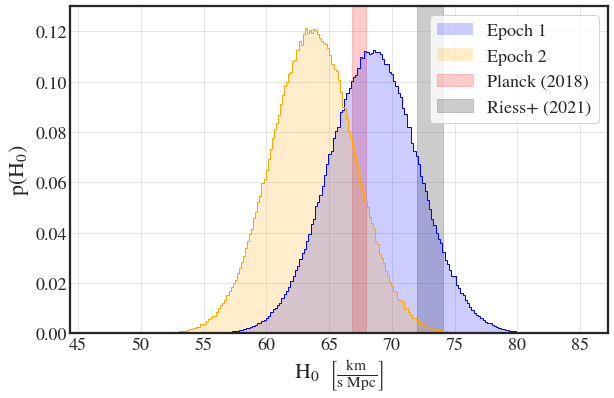

In [466]:
z_arr_1 = np.random.normal(loc=z, scale=0.00050, size=len(dl_arr[0]))
H0_arr_1 = 1/dl_arr[0]*3e5*z_arr_1*(1+1.53/2*z_arr_1)

z_arr_2 = np.random.normal(loc=z, scale=0.00050, size=len(dl_arr[1]))
H0_arr_2 = 1/dl_arr[1]*3e5*z_arr_2*(1+1.53/2*z_arr_2)

#z_arr_3 = np.random.normal(loc=z, scale=0.00050, size=len(dl_arr[2]))
#H0_arr_3 = 1/dl_arr[2]*3e5*z_arr_3*(1+1.53/2*z_arr_3)

plt.figure(figsize=(9,6))
plt.hist(H0_arr_1, bins=200, histtype='step', color=color_list[0], density=True); 
plt.hist(H0_arr_1, bins=200, alpha=0.2      , color=color_list[0], density=True, label='Epoch 1'); 
plt.hist(H0_arr_2, bins=200, histtype='step', color=color_list[1], density=True); 
plt.hist(H0_arr_2, bins=200, alpha=0.2      , color=color_list[1], density=True, label='Epoch 2'); 
#plt.hist(H0_arr_3, bins=200, histtype='step', color=color_list[2], density=True); 
#plt.hist(H0_arr_3, bins=200, alpha=0.2      , color=color_list[2], density=True, label='Epoch 3'); 
plt.ylabel(r'p(${\rm H_0}$)'), plt.xlabel(r'${\rm H_0} \ \ \left[\frac{\rm km}{\rm s \ Mpc}\right]$')

plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [-2, -2], [2, 2], color='red', alpha=0.2, label='Planck (2018)' )
plt.fill_between([H0_sn-dH0_sn, H0_sn+dH0_sn], [-2, -2], [2, 2], color='grey', alpha=0.4, label='Riess+ (2021)' )
plt.ylim(0, 0.13)

plt.legend(frameon=True, fontsize=18, loc=1)
plt.ticklabel_format(style='plain')
plt.tight_layout()
#plt.savefig('Pictures/Posterior_H0_inflated.png', dpi=300)

In [407]:
len(H0_arr_2[H0_arr_2>H0_sn-dH0_sn])/len(H0_arr_2)

0.017476923076923077

In [294]:
z

0.00985

In [295]:
print(r'Given D_L=', mu,r'pm', sigma)
sample = np.random.normal(loc=mu, scale=sigma, size=100000)
z_arr = np.random.normal(loc=0.00986, scale=0.00049, size=100000)

Given D_L= 45.42944957209401 pm 0.6052028569528516


65.61228649758448 3.4008736938961426


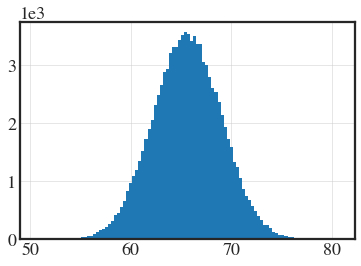

In [296]:
H0_arr = 1/sample*3e5*z_arr*(1+1.53/2*z_arr)
plt.hist(H0_arr, bins=100); 
print(np.mean(H0_arr), np.std(H0_arr))

In [520]:
upsilon_planck, np.std(upsilon_planck)

([array(0.00442665), array(-0.02409917)], 0.014262908391251427)

In [295]:
H0_s1[50]

67.62626262626263

In [529]:
print('Middle = ', interp1d(H0_s1, upsilon_s_1)(H0_p))
print('High = '  , interp1d(H0_s1, upsilon_s_up * (0.00049 +0.00957)/0.00957)(H0_p-dH0_p))
print('Low  = '  , interp1d(H0_s1, upsilon_s_low * (-0.00049+0.00957)/0.00957)(H0_p+dH0_p)) 

print( (interp1d(H0_s1, upsilon_s_low * (-0.00049+0.00957)/0.00957)(H0_p+dH0_p)-
     interp1d(H0_s1, upsilon_s_up * (0.00049 +0.00957)/0.00957)(H0_p-dH0_p))/2 )

Middle =  -0.02409916720715042
High =  0.0005171645001376753
Low  =  -0.04613879042484722
-0.023327977462492447


In [531]:
#plt.figure(figsize=(8,6))
#plt.errorbar(n_days[:3], upsilon_planck, yerr = 0.022, fmt='.', capsize=5)
#plt.ylim(-0.24, 0.24), plt.xlim(0, 5); 
#plt.ticklabel_format(style='plain')
#plt.ylabel(r'$\Upsilon$'), plt.xlabel('Time post merger [days]')

In [532]:
for i in [0]: 
    for idx, file in enumerate([files[i]]):
        pickle_in = open(file,"rb")
        emcee_res = pickle.load(pickle_in)
        emcee_flatten = emcee_res.flatchain
        
        H0_s1 = 67.54 #73.04 # # np.linspace(55, 80, 100)
        dl_s1 = 1/H0_s1*3e5*z*(1+1.53/2*z)
        
        N_1      = ( np.array(emcee_flatten['N'])     )
        v_phot_1 = ( np.array(emcee_flatten['vphot']) )
        #R_1 = np.sqrt( np.array(N_1)*10**7  ) *(dl_s1*3.086e+24)
        #v_sn_1 = R_1/n_days[i]/(24*3600*3e10)/inter(v_phot_1)**2 #* (np.sqrt(inter(v_phot_1)))
        
        #R_1 = np.sqrt( np.array(N_1)*10**7/np.pi* inter(v_phot_1)  ) *(dl_s1*3.086e+24)
        R_1 = np.sqrt( np.array(N_1)*10**7/np.pi* inter(v_phot_1)**2  ) *(dl_s1*3.086e+24)
        v_sn_1 = R_1/n_days[i]/(24*3600*3e10) 
        
np.mean(v_sn_1), np.std(v_sn_1)+np.mean(v_sn_1)*0.042, np.mean(v_sn_1)*0.042

(0.5397496178183565, 0.02376144225193307, 0.022669483948370976)

In [260]:
((72/299792.458)**2 + (0.00043)**2)**(1/2)

0.0004925238866347699

In [281]:
385/299792.458

0.0012842217665128854

In [482]:
print(np.array([3327,72])/299792.458)
np.array([3327])/299792.458 - np.array([0.00124]), np.array([3327])/299792.458 - np.array([0.00128])

[0.01109768 0.00024017]


(array([0.00985768]), array([0.00981768]))

### Describe $\chi^2$-squares

In [8]:
loc = [0.999, 0.99, 0.98]
scale = [0.016, 0.018, 0.020]

0.27793590677592556


TypeError: lum_dist_arr() missing 1 required positional argument: 'v_perp'

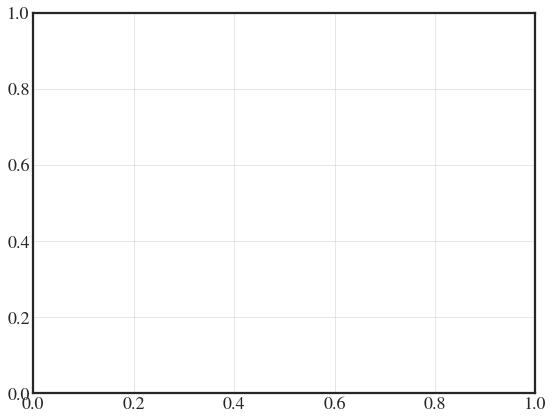

In [495]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.415, 3.42, 4.40, 5.40]

mini = 35
maxi = 49

files = ["./data/OB1/OB1_3_peaks_with_gaussian_2.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9,7))
    
steady = [22*1500, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', '3.40 days','Joint']
for idx, file in enumerate(files[:3]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.normal(loc=0.996, scale=scale[idx], size=len(emcee_flatten['vphot']))
    
    #*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h1 = plt.hist(dl, bins=400, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h1 = plt.hist(dl, bins=400, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h1[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(mini, maxi)

mini = 35
maxi = 55

##p1,p2 = pdf_list
##dh = h1[1][1]-h1[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
##ax.plot(np.linspace(mini, maxi, 1000), 
##         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
##         , color='red', alpha=1 )
##ax.fill_between(np.linspace(mini, maxi, 1000), 
##         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
##                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(41, 44, 100)-mu)**2/(2*sigma**2))
plt.plot( np.linspace(41, 44, 100), 
         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')
plt.legend(frameon=True, fontsize=17, loc=2,  title="Kilonova EPM distance")
y_max = 1.65; ax.set_ylim(0,y_max)





ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/4); plt.grid(False); 
ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); plt.ylabel(r'$p(D_L)$')#"", color='green')


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=True, fontsize=17, loc=1)#(0.02, 0.55))

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/4); ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.3**2)*np.exp(-(39.6-dists)**2/(2*3.3**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=17, 
          loc = (0.7,0.6), #for left loc=(0.02,0.485), 
          title = 'Redshift Distance', handlelength=1.2)

#plt.savefig('Pictures/dl_dist_15.png', dpi=300)


44.4258371979799
46.39521210111809


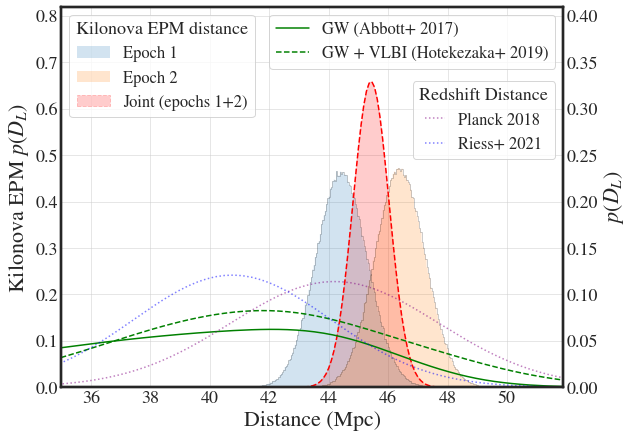

In [548]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.427, 2.41, 3.42, 4.40, 5.40]

mini = 35
maxi = 51.9

files = ["./data/OB1/OB1_3_peaks_with_gaussian_2.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB3_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9,7))
    
steady = [22*1500, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

#loc = [1.00, 1.00, 1.00, 0.93]
#scale = [0, 0,0]#[0.016, 0.018, 0.020, 0.050]

titles = ['Epoch 1', 'Epoch 2', '3.40 days','4.40 days']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])
    vphot2 = np.array(emcee_flatten['vphot'])*np.random.normal(loc=loc[idx], scale=scale[idx], size=len(emcee_flatten['vphot']))
    #print(np.median(vphot))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, vphot2, 
                      n_days=n_days[idx])[steady[idx]:]
    
    h1 = plt.hist(dl, bins=400, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h1 = plt.hist(dl, bins=400, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h1[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)

    print(np.median(dl))
    
#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 

##p1,p2 = pdf_list
##dh = h1[1][1]-h1[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
##ax.plot(np.linspace(mini, maxi, 1000), 
##         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
##         , color='red', alpha=1 )
##ax.fill_between(np.linspace(mini, maxi, 1000), 
##         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
##                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1[:2]**2)**(-1/2)
mu = np.sum(1/sig1[:2]**2/np.sum(1/sig1[:2]**2)*d_m[:2])
combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(41, 50, 100)-mu)**2/(2*sigma**2))
plt.plot( np.linspace(41, 50, 100), 
         combined, color='red', ls='--', alpha=1)
plt.fill_between( np.linspace(41, 50, 100), 
         combined, color='red', ls='--', alpha=0.2, label='Joint (epochs 1+2)')
plt.legend(frameon=True, fontsize=16.5, loc=2,  title="Kilonova EPM distance")
#y_max = 1.11; ax.set_ylim(0,y_max)
y_max = 0.82; ax.set_ylim(0,y_max)





ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/2); plt.grid(False); 
ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); 
plt.ylabel(r'$p(D_L)$'), #ax2.set_yticks([])


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW (Abbott+ 2017)', 'GW + VLBI (Hotekezaka+ 2019)'], frameon=True, fontsize=16.5, loc=1)#(0.02, 0.55))

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/2); ax3.ticklabel_format(style='plain'); ax3.grid(False)
ax3.set_yticks([])

lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(44.2-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.3**2)*np.exp(-(40.76-dists)**2/(2*3.3**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=16.5, 
          loc = (0.7,0.6), #for left loc=(0.02,0.485), 
          title = 'Redshift Distance', handlelength=1.2)

plt.xlim(mini, maxi)
plt.savefig('Pictures/Final/PDF/dl_dist_2.pdf', dpi=300)


In [208]:
42.59401357417827, 38.85466878444085

(42.59401357417827, 38.85466878444085)

In [249]:
mu, sigma

(45.37210443688625, 0.6055103022018454)

In [52]:
1/73.03*3e5*0.00985*(1+1.53/2*0.00985)

40.76772098795016

In [278]:
1/67.54*3e5*0.00985*(1+1.53/2*0.00985)

44.08153188851051

### Plot of parameters vs. time

In [89]:
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 


T_list = []; N_list = []; vphot_list = []; 
dT_list = []; dN_list = []; dvphot_list = []; 

for i in range(5): 
    pickle_in = open(files[i],"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    T, N, vphot = emcee_res.params['T'], emcee_res.params['N'], emcee_res.params['vphot']
    
    T_list.append(T), N_list.append(N), vphot_list.append(vphot)
    dT_list.append(T.stderr), dN_list.append(N.stderr), dvphot_list.append(vphot.stderr)
    
v_perp = np.array( np.sqrt(np.array(N_list)*1e7/np.pi)*inter(np.array(vphot_list)) * (44.2 * 3.086e+24) / n_days /(24*3600*3e10)   )

Text(0.5, 66.5, 'Time from merger [days]')

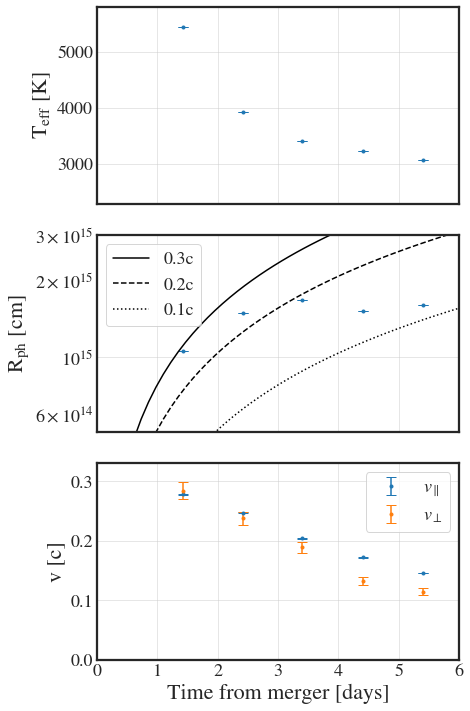

In [153]:
fig, ax = plt.subplots(figsize=(7,10), nrows=3, sharex=True)

ax[0].errorbar(n_days, np.array(T_list), yerr=np.array(dT_list), fmt='.', capsize=5)
ax[0].set_ylim(2300, 5800), ax[0].set_ylabel(r'$\rm{T}_{\rm eff}$ [K]')
ax[0].ticklabel_format(style='plain'); ax[2].ticklabel_format(style='plain')

ax[1].errorbar(n_days, np.sqrt(np.array(N_list)*1e7/np.pi) *inter(np.array(vphot_list))*(44.2 * 3.086e+24), 
               yerr=np.array(dvphot_list), fmt='.', capsize=5)
ax[1].set_ylim(0.51e15, 3e15), ax[1].set_ylabel(r'$\rm{R}_{\rm ph}$ [cm]'), ax[1].set_yscale('log')
ax[1].plot( np.linspace(0, 6), np.linspace(0, 6)*0.3*c * 24*3600*100, color='k', label='0.3c')
ax[1].plot( np.linspace(0, 6), np.linspace(0, 6)*0.2*c * 24*3600*100, color='k', label='0.2c', ls='--')
ax[1].plot( np.linspace(0, 6), np.linspace(0, 6)*0.1*c * 24*3600*100, color='k', label='0.1c', ls='dotted')
ax[1].legend(frameon=True, fontsize=18)

ax[2].errorbar(n_days, np.array(vphot_list), yerr=np.array(dvphot_list), label='$v_{\parallel}$', fmt='.', capsize=5)
ax[2].errorbar(n_days, v_perp, yerr = v_perp*0.048, label='$v_{\perp}$', fmt='.', capsize=5)
ax[2].set_ylim(0, 0.33), ax[2].set_ylabel('v [c]'), ax[2].legend(frameon=True, fontsize=18)

plt.xlim(0, 6); plt.subplots_adjust(hspace=0.05)
plt.tight_layout(); plt.xlabel('Time from merger [days]')

#plt.savefig('Pictures/Properties.png', dpi=300)